# Convergence and Optimality Analysis of Low-Dimensional Generative Adversarial Networks using Error Function Integrals

## Requirements

Use `requirements.txt` file preferably in virtual environment.

In order to do that in the current folder, for Ubuntu:
```
$ sudo apt install virtualenv
$ virtualenv venv
$ source venv/bin/activate
(venv)$ pip install -r requirements.txt
(venv)$ python -m ipykernel install --user --name=venv
```

Launch from command prompt: 
```bash
(venv)$ jupyter notebook
```

or open it within VSCode with [Jupyter extension](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter) or any other favorite method. Please make sure that the Jupyter kernel points to your environment (select it from the kernel menu).

## Imports

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

from scipy.io import savemat 
from tqdm import tqdm

In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
sys.path.append('src')

In [45]:
from utils import load_analytical
from sgd import SGD_gh
from gan import sample_xz

## Common notes
Objective function (from Goodfellow's paper):
$$
V[G,D] = \mathbb{E}_x \log D(x) + \mathbb{E}_z \log(1 - D(G(z))
$$

The goal is to optimize
$$
\min_G \max_D V[G, D]
$$

The assumption of Goodfellow's paper is that we can find an algorithm which finds globally optimal $D^*, G^*$. Let's see if we can optimize for some simple case, introducing some new levels of complexity if we need them. If the approach of Gf is formulated for a very common case, it should work for a basic one.

A least squares GAN cost function is:
$$
V[G, D] = E_x D^2(x) + E_z [1 - D(G(z))]^2
$$

# Analysis of some case of `x` and `z` distribution


Here we assume
$$
x \sim \text{Exp}(c) \\
z \sim \text{Rayleigh}(1) \\
D(x) = {1 + \Phi(ax + b) \over 2} \\
G(z) = g z^2 + h
$$

Where
$$
\text{Exp}(c) = c e^{-c x} \\
\text{Rayleigh}(1) = 2x \exp(-x^2)
$$

Augmented cost function
$$
V[D,G] = \mathbb{E}_x D^2(x) + \mathbb{E}_z [1 - D(G(z))]^2 = J_1[D] + J_2[D,G]
$$

Therefore
$$
J_1[D] = \frac{1}{4}\int_0^{\infty} (1+\Phi(ax + b))^2 \text{Exp}(x|c) dx \\
J_2[D, G] = \\
\frac{1}{4g}\int_0^{\infty} [1 - \Phi(a\zeta + \eta)]^2 \text{Exp}(\zeta|1/g) dz
$$
where $\eta=ah+b$ and $\zeta=gz^2$


## Cost function computed using sampling
Easiest way (the one, which Goodfellow also follows):
$$
V[G,D] = {1 \over m} \sum_{i = 1}^m
D^2(x_i) + [1 - D(G(z_i))]^2
$$

## SGD implementation
Here we implement vanilla SGD for the example above.

${\partial J \over \partial g}$, ${\partial J \over \partial h}$ are defined in `sgd.py` module.

Single SGD step:
$$
g \leftarrow g + \epsilon_g {\partial J \over \partial g} \\
h \leftarrow h - \epsilon_h {\partial J \over \partial h}
$$

SGD procedure:

In [46]:
def run_SGD(config_gan, config_sgd, x, z):
  a, b, c, _, _ = [v[1] for v in config_sgd.items()]
  g_initial, h_initial, eps_b, eps_h, n_steps = [v[1] for v in config_gan.items()]
  gd = SGD_gh(x, z, a, b, c, g_initial, h_initial, eps_b, eps_h, n_steps)
  path = [val for val in gd]
  g_path = [val[0] for val in path]
  h_path = [val[1] for val in path]
  return g_path, h_path

In [47]:
def run_SGD_batch(config_gan, config_sgd, n_runs=100, n_samples=10_000):
  g_paths = []
  h_paths = []
  for _ in tqdm(range(n_runs)):
    x, z = sample_xz(config_gan, n_samples=n_samples)
    g_hat, h_hat = run_SGD(config_sgd, config_gan, x, z)
    g_paths += [g_hat]
    h_paths += [h_hat]
  return g_paths, h_paths

## Plot utility

In [98]:
def plot_comparison(config_gan, config_sgd, g_paths, h_paths, fname_analytical, fname_output):
    analytical = load_analytical(fname_analytical, 'Theta')
    fig, _ = plt.subplots()
    plt.grid(True)
    plt.plot(analytical, label=['analytical $g_0$ = 0.9', 'analytical $h_0$ = -1.5'])
    plt.plot(np.array(g_paths).transpose(), color='lightblue')
    plt.plot([], [], label='$g$ MC', color='lightblue')
    plt.plot(np.array(h_paths).transpose(), color='peachpuff')
    plt.plot([], [], label='$h$ MC', color='peachpuff')
    n_steps = config_sgd['n_steps'] - 1
    plt.plot(n_steps, 1.0/config_gan["c"], marker='o', linestyle='None',
             label='optimal $g^*$', color='lightblue', markeredgecolor='black')
    plt.plot(n_steps, 0, marker='o', linestyle='None',
             label='optimal $h^*$', color='orange', markeredgecolor='black')
    plt.legend()
    fig.savefig(fname_output, format='pdf')
    plt.show()

### Test case implementation
Configuration:

In [48]:
config_gan = {
    "a": None,
    "b": None,
    "c": 2.1,
    "g": None,
    "h": None,
}
config_sgd = {
    "g_initial": 0.8,
    "h_initial": -1.6,
    "eps_g": 0.4,
    "eps_h": 0.4,
    "n_steps": 50
}

MC SGD experiment:

In [49]:
g_paths, h_paths = run_SGD_batch(config_gan=config_gan, config_sgd=config_sgd, n_runs=50)

100%|██████████| 50/50 [05:05<00:00,  6.11s/it]


In [57]:
savemat('content/python_gh_test_case_c_2.1_g_0.9_h_-1.5.mat', {'g_paths': g_paths, 'h_paths': h_paths})

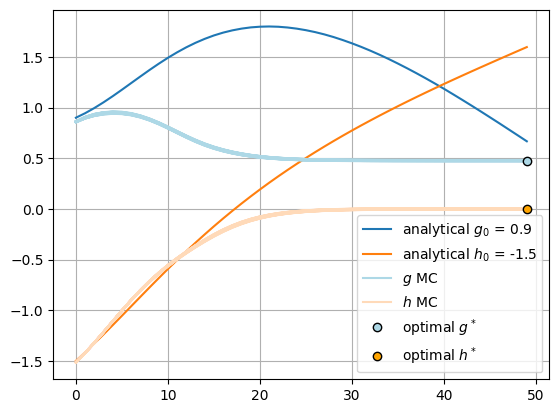

In [99]:
plot_comparison(config_gan=config_gan,
                config_sgd=config_sgd,
                g_paths=g_paths, 
                h_paths=h_paths, 
                fname_analytical='content/gh_test_case_c2_1_g0_9_h1_5.mat',
                fname_output='content/gh_test_case_c2_1_g0_9_h1_5.pdf')